<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Михаил Мельник (m.v.melnick@gmail.com)

## <center> Индивидуальный проект по анализу данных </center>
### <center> "Прогнозирование бронирований на AirBnB" </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

#### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import make_scorer
from scipy.sparse import csr_matrix, hstack, vstack
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import learning_curve

%matplotlib inline
# figure size in inches
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
plt.rcParams['figure.figsize'] = 16,9

In [2]:
def create_submission(predict, id_vals, enc, filename):
    # Для каждого ID пользователя отбираем 5 классов с максимальной предсказанной вероятностью
    ids = []  # спикок ID пользователей
    cts = []  # список стран
    for i in range(len(id_vals)):
        idx = id_vals[i]
        ids += [idx] * 5
        cts += enc.inverse_transform(np.argsort(predict[i])[::-1])[:5].tolist()
    #Generate submission
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(filename, index=False) 

In [3]:
# Реализация вычисления целевой метрики NDCG
def my_ndcg(y_true, y_predict, k=5):
    ndcg = 0
    n = 0
    for y_true_val, y_predict_vec in zip(y_true, y_predict):
        #print(y_true_val, y_predict_vec)
        order = np.argsort(y_predict_vec)[::-1][:k]
        #print(order)
        for idx, y_predict_val in enumerate(order):
            if y_true_val == y_predict_val:
                #print(1 / np.log2(idx + 2))
                ndcg += 1 / np.log2(idx + 2)
                break
        n += 1
    #print(ndcg)
    return ndcg / n

In [4]:
ndcg_scorer = make_scorer(my_ndcg, needs_proba=True, k=5)

###  Часть 1. Описание набора данных и признаков

#### Введение

AirBnB - это онлайн-площадка для размещения, поиска и краткосрочной аренды частного жилья по всему миру. Пользователи Airbnb имеют возможность сдавать путешественникам в аренду своё жильё целиком или частично. Сайт предоставляет платформу для установления контакта между хозяином и гостем, а также отвечает за обработку транзакций.

Данный индивидуальный проект посвящен задаче прогнозирования страны первого бронирования жилья для новых пользователей AirBnb (*задача многоклассовой классификации*). Ценность этой задачи для бизнеса состоит в том, что правильное прогнозирование места первого бронирования позволит делать пользователям персонализированные предложения (баннеры на сайте, рассылка по почте). Это в свою очередь должно снизить среднее время от регистрации нового пользователя до первого бронирования, что повысит конверсию пользователей и благотворно скажется на финансовом результате компании.

#### Описание набора данных и признаков

Набор данных получен из Kaggle ([Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data)) и включает несколько файлов с данными о пользователях (вкл. социально-демографические данные) и пользовательских веб-сессиях:
* *train_users.csv* - обучающая выборка данных о пользователях.

|               Переменная | Описание |
|--------------------------|----------|
|                       id | ID пользователя |
|     date_account_created | Дата создания аккаунта на airbnb |
|   timestamp_first_active | Дата и время первой активности на сайте airbnb.com |
|       date_first_booking | Дата первого бронирования |
|                   gender | Пол |
|                      age | Возраст |
|            signup_method | Способ регистрации (базовый, профиль facebook или google) |
|              signup_flow | Страница, с которой пользователь перешел для регистрации |
|                 language | Предпочитаемый язык |
|        affiliate_channel | Тип рекламы |
|       affiliate_provider | Провайдер рекламы |
|  first_affiliate_tracked | Первый тип рекламы, с которым взаимодействовал пользователь перед регистрацией |
|               signup_app | Приложение, с которого была регистрация |
|        first_device_type | Тип первого девайса пользователя |
|            first_browser | Первый браузер пользователя |
|  **country_destination** | **Целевая переменная** - страна первого бронирования |

* *test_users.csv* - тестовая выборка данных о пользователях. Структура аналогична train_users.csv за исключением отсутсвия целевой переменной country_destination.

* *sessions.csv* - данные о web-сессиях пользователей (клики, обновление wish-листов, поиск и др.). Будет использоваться для обогащения основных признаков по пользоватлям.

|               Переменная |          Описание |
|--------------------------|-------------------|
|                       id |   ID пользователя |
|                   action | Действие на сайте |
|              action_type | Тип действия |
|            action_detail | Детализация действия |
|            device_type | Тип девайса |
|            secs_elapsed | Длительность действия |


#### Общие замечания по исходным данным

* Все пользователи в предоставленных данных из США.
* Имеются 12 возможных значений целевой переменной - страны первого бронирования: US (США), FR (Франция), CA (Канада), GB (Великобритания), ES (Испания), IT (Италия), PT (Португалия), NL (Нидерланды), DE (Германия), AU (Австралия), NDF (no destination found), and 'other' (другое).
* 'other' (другое) - означает, что пользователь сделал бронирование, но страна бронирования не входит в приведенный выше список. А 'NDF' означает, что первого бронирования не было.
* Тестовые и обучающие наборы данных не пересекаются по датам. В тестовом наборе данных нужно спрогнозироать страну первого бронирования для пользователей, у которых первые активности на airbnb (регистрация, поиск, клики) состоялись после 01.07.2014.

###  Часть 2. Первичный анализ признаков

#### Загружаем исходные данные

In [5]:
df_train = pd.read_csv('../data/train_users_2.csv')
df_test = pd.read_csv('../data/test_users.csv')

In [6]:
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

Итак, у нас имеются данные по *213451* пользователям в обучающей выборке и *62096* пользователям в тестовой.

#### Первичный осмотр данных

In [7]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [8]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


Выводы по первичному осмотру данных:
* По крайней мере в двух признаках (date_first_booking и age) есть пропуски. Далее мы исследуем этот вопрос подробнее.
* В наборе данных очень много категориальных признаков. Соответственно, далее их нужно будет преобразовывать.
* Признак timestamp_first_active нужно преобразовать к нормальному типу timestamp.

In [9]:
# Создадим объединенный набор данных - будет полезно для некоторых дальнейших исследований
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
# Удалим из объединенного датасета ID пользователя - он пока не нужен
df_all.drop('id', axis=1, inplace=True)

In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
country_destination        213451 non-null object
date_account_created       275547 non-null object
date_first_booking         88908 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              275547 non-null object
first_device_type          275547 non-null object
gender                     275547 non-null object
language                   275547 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(12)
memory usage: 31.5+ MB


#### Профилирование категориальных переменных

В нашем наборе данных много категориальных переменных. Давайте исследуем распределение их значений.

In [11]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [12]:
for cat_feat in categorical_features:
    heading = "Profile for {}".format(cat_feat)
    print("*" * len(heading))
    print(heading)
    print("*" * len(heading))
    print(df_all[cat_feat].value_counts())
    print("\n")

*****************************
Profile for affiliate_channel
*****************************
direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64


******************************
Profile for affiliate_provider
******************************
direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64


****

Замечания по результатам профилирования категориальных признаков:
* В некоторых признаках встречаются значения -unknown- - это очевидно пропущенные значению. Нужно принять это во внимание при очистке данных.
* Распределение целевой переменной говорит о том, что подавляющее большинство пользователей (по факту 90%) попадает в две категории - они либо еще не сделали бронирование, либо сделали первое бронирование в США. На это стоит обратить внимание при моделировании, т.к. сильно обобщенная модель может выдавать только два прогноза - NDF и USA.

#### Переменная возраст (Age)

In [13]:
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [14]:
df_all.age.min()

1.0

In [15]:
df_all.age.max()

2014.0

In [16]:
df_all.age.value_counts()

30.0      7712
28.0      7687
29.0      7647
31.0      7540
27.0      7462
32.0      7187
33.0      6795
26.0      6745
34.0      6176
25.0      6149
35.0      5949
36.0      5032
24.0      4571
37.0      4474
38.0      4091
39.0      3642
23.0      3516
40.0      3327
41.0      3098
42.0      2731
45.0      2669
44.0      2584
22.0      2508
43.0      2486
46.0      2317
19.0      2023
47.0      2006
48.0      1779
50.0      1679
51.0      1630
          ... 
1949.0       3
1936.0       2
1920.0       2
111.0        2
1938.0       2
1929.0       2
1923.0       2
1926.0       2
1944.0       2
1951.0       2
1940.0       2
1942.0       1
2002.0       1
150.0        1
1952.0       1
1945.0       1
2008.0       1
1939.0       1
2000.0       1
1995.0       1
1948.0       1
1968.0       1
1930.0       1
1941.0       1
1922.0       1
1954.0       1
1953.0       1
132.0        1
1937.0       1
112.0        1
Name: age, Length: 145, dtype: int64

Мы видим, что в переменной age встречаются странные значения - больше 120 и меньше 10.

In [17]:
sum(df_all.age > 120)

830

In [18]:
sum(df_all.age < 10)

59

На этапе предобработки такие данные потребуют особого внимания.

#### Пропущенные значения

Для более объективной картины по пропущенным значениям заменим значения '-unknown-' в некоторых категориальных признаках на стандартное неопределенное значение np.nan.

In [19]:
df_all.gender.replace('-unknown-', np.nan, inplace=True)
df_train.gender.replace('-unknown-', np.nan, inplace=True)
df_test.gender.replace('-unknown-', np.nan, inplace=True)

df_all.language.replace('-unknown-', np.nan, inplace=True)
df_train.language.replace('-unknown-', np.nan, inplace=True)
df_test.language.replace('-unknown-', np.nan, inplace=True)

df_all.first_browser.replace('-unknown-', np.nan, inplace=True)
df_train.first_browser.replace('-unknown-', np.nan, inplace=True)
df_test.first_browser.replace('-unknown-', np.nan, inplace=True)

Проведем исследование пропущенных значений отдельно для обучающей и тестовой выборки.

In [20]:
df_train_missing = df_train.isnull().sum() / df_train.shape[0]
df_train_missing[df_train_missing > 0]

date_first_booking         0.583473
gender                     0.448290
age                        0.412226
first_affiliate_tracked    0.028414
first_browser              0.127739
dtype: float64

In [21]:
df_test_missing = df_test.isnull().sum() / df_test.shape[0]
df_test_missing[df_test_missing > 0].drop('date_first_booking')

gender                     0.544190
age                        0.465022
language                   0.000016
first_affiliate_tracked    0.000322
first_browser              0.275831
dtype: float64

В наших данных много пропусков в переменных gender, age, date_first_booking и first_browser. 
Переменная date_first_booking связана с целевой переменной и ее пропуски обусловлены значением NDF целевой переменной. По остальным переменным с пропусками нужно будет выбрать стратегии обработки.

###  Часть 3. Первичный визуальный анализ признаков

#### Распределение целевой переменной

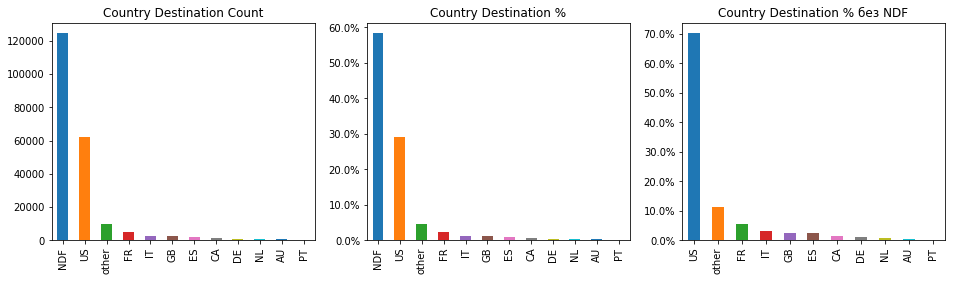

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

country_counts = df_train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count', ax=axes[0])

ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])

booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % без NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()]);

Графики подтверждают наши наблюдения, сделанные ранее - большая часть значений целевой переменной относятся к двум классам - NDF (не сделавшие бронирование) и USA.

#### Распределение целевой переменной с учетом пола

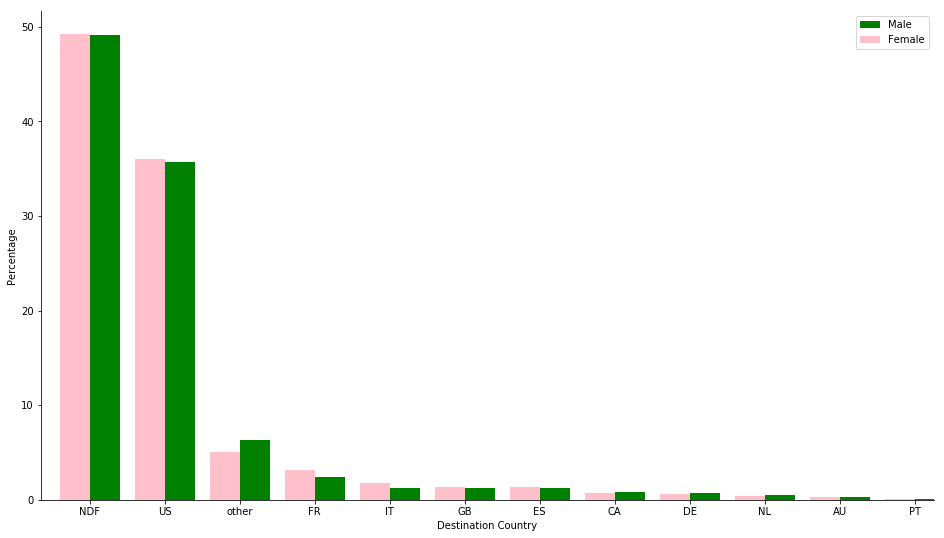

In [23]:
women = sum(df_train['gender'] == 'FEMALE')
men = sum(df_train['gender'] == 'MALE')

female_destinations = df_train[df_train['gender'] == 'FEMALE'].country_destination.value_counts() / women * 100
male_destinations = df_train[df_train['gender'] == 'MALE'].country_destination.value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='green', position=0, label='Male', rot=0, figsize=(16, 9))
female_destinations.plot(kind='bar', width=width, color='pink', position=1, label='Female', rot=0, figsize=(16, 9))

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Судя по графику, практически нет различий в предпочтениях мужчин и женщин.

#### Распределение целевой переменной с учетом возраста

C:\Users\MIHA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


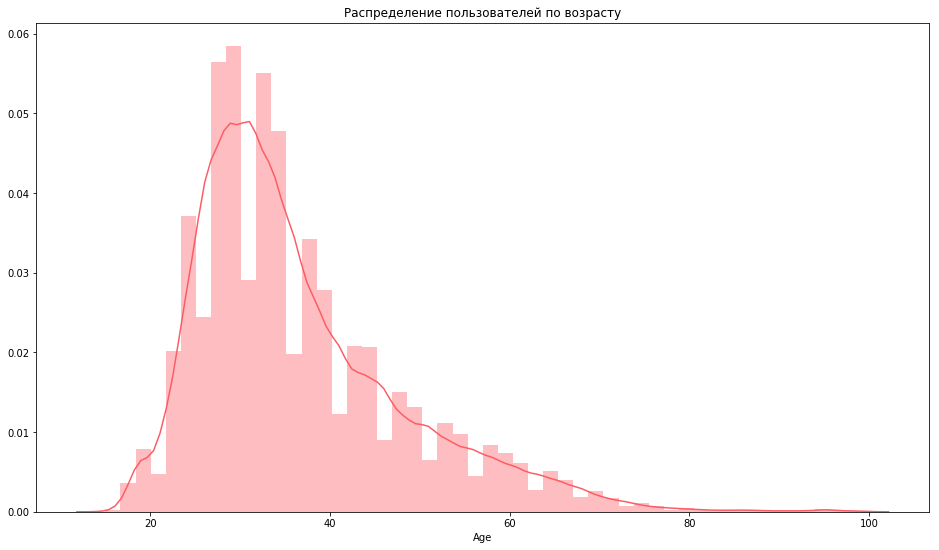

In [25]:
sns.distplot(df_train[(df_train.age < 100)&(df_train.age > 10)].age.dropna(), color='#FD5C64')
plt.title("Распределение пользователей по возрасту")
#plt.figsize = (16, 9)
plt.xlabel('Age')
plt.rcParams['figure.figsize'] = 16,9

AirBnb наиболее популярен среди пользователей от 25 до 40 лет.

In [26]:
age_data = df_train[(df_train.age < 100)&(df_train.age > 10)]

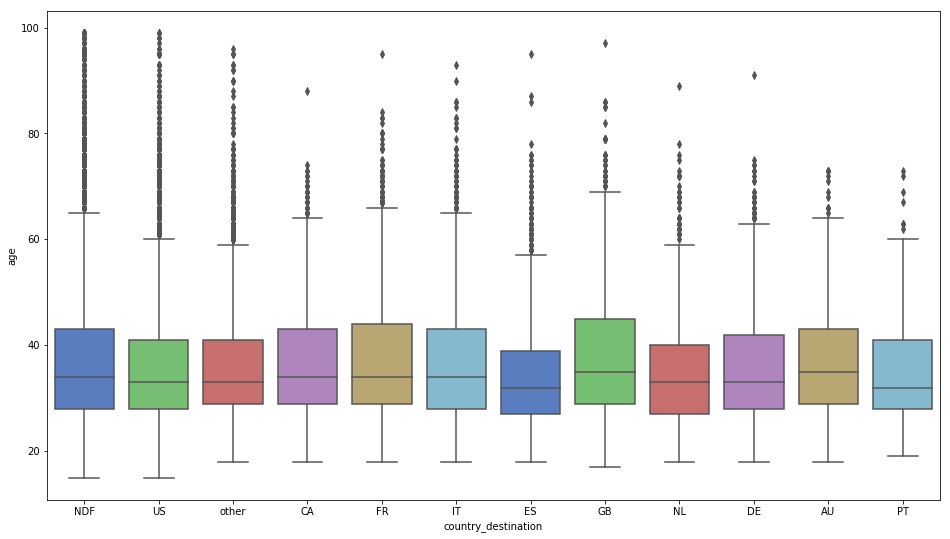

In [27]:
sns.boxplot(x='country_destination', y='age', data=age_data, palette="muted");

На этом графике не видно больших различий бронирования в зависимости от возраста пользователя.

Попробуем посмотреть на распределение целевой переменной по возрасту на двух частях выборки, разделенных медианой.

In [28]:
age_data.age.median()

34.0

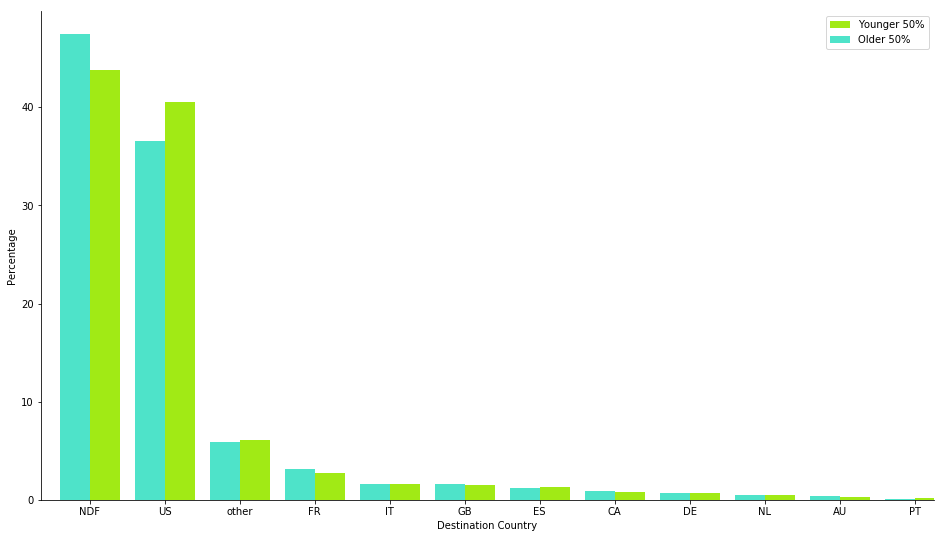

In [29]:
age = age_data.age.median()

younger = sum(age_data['age'] < age)
older = sum(age_data['age'] > age)

younger_destinations = age_data[age_data['age'] < age].country_destination.value_counts() / younger * 100
older_destinations = age_data[age_data['age'] > age].country_destination.value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#A1EA15', position=0, label='Younger 50%', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4EE3C9', position=1, label='Older 50%', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

На этом графике видно, что "более молодая" половина делает чаще первое бронирование после регистрации (меньше доля NDF) и в то же время чаще делает бронирование в США.

#### Временные признаки

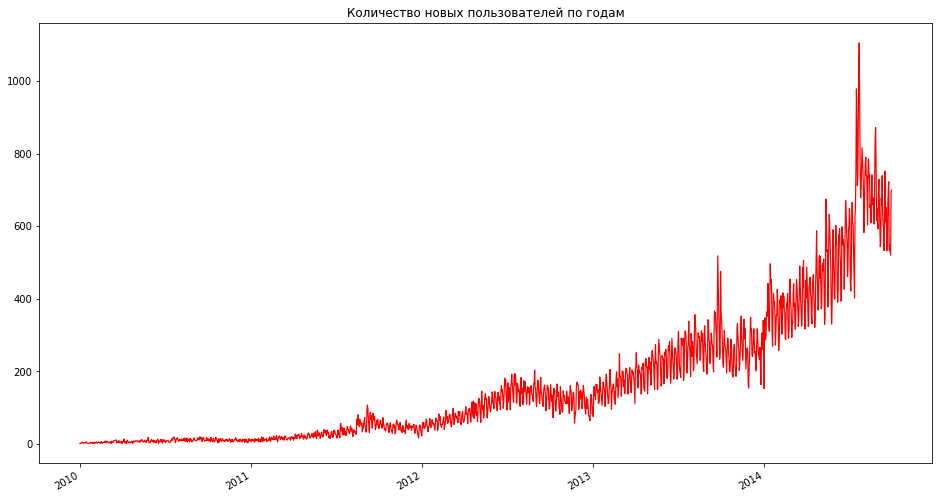

In [30]:
#sns.set_style("whitegrid", {'axes.edgecolor': '0'})
#sns.set_context("poster", font_scale=1.1)
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all.date_account_created.value_counts().sort_index().plot(kind='line', linewidth=1.2, color='red')
plt.title("Количество новых пользователей по годам");

Мы видим экспоненциальный рост количества пользователей по времени.

###  Часть 4. Закономерности, "инсайты", особенности данных

Выше вы уже отмечали найденные особенности в данных. Соберем их здесь вместе:
* Распределение целевой переменной говорит о том, что подавляющее большинство пользователей (по факту 90%) попадает в две категории - они либо еще не сделали бронирование, либо сделали первое бронирование в США. На это стоит обратить внимание при моделировании, т.к. сильно обобщенная модель может выдавать только два прогноза - NDF и USA.
* Мы видим экспоненциальный рост количества пользователей по времени. Причем скорость роста усиливается с 2014 года. Возможно имеет смысл использовать для моделирования более свежие данные (начиная с 2014 года).
* В данных довольно много пропусков (и некорректных значений) по полу и возрасту. Часть некорректных значений по возрасту можно будет восстановить, т.к. некоторые пользователи вместо возраста ввели год рождения (например, 1951). Пропущенные значения связаны, скорее всего, с нежеланием пользователей раскрывать свои личные данные.
* Мы не обнаружили различий в распределении целевой переменной по полу и возрасту. Для моделирования потребуется более глубокий анализ и создание новых признаков.
* Пользователи с возрастом меньше медианного (половина выборки) более часто делают первое бронирование, чем вторая половина пользователей.
* Переменная date_first_booking связана с целевой переменной и заполнена только в обучающей выборке. Она не может быть использована для обучения модели, поэтому ее следует удалить из обучающей выборки.

###  Часть 5. Предобработка данных 

#### Скорректируем форматы переменных, связанных с датами и временем

In [31]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])

df_train['timestamp_first_active'] = pd.to_datetime(df_train['timestamp_first_active'], format='%Y%m%d%H%M%S')
df_test['timestamp_first_active'] = pd.to_datetime(df_test['timestamp_first_active'], format='%Y%m%d%H%M%S')

Переменная date_first_booking связана с целевой переменной и заполнена только в обучающей выборке, поэтому ее следует удалить:

In [32]:
df_train.drop('date_first_booking', axis=1, inplace=True)
df_test.drop('date_first_booking', axis=1, inplace=True)

#### Обработка переменной Age

Часть пользователей ввели год рождения вместо возраста. Попробуем восстановить их возраст.

In [33]:
train_with_year_age_mask = df_train['age'] > 1900
df_train.loc[train_with_year_age_mask, 'age'] = 2015 - df_train.loc[train_with_year_age_mask, 'age'] # соревнование 2015г

In [34]:
test_with_year_age_mask = df_test['age'] > 1900
df_test.loc[test_with_year_age_mask, 'age'] = 2015 - df_test.loc[test_with_year_age_mask, 'age']

Значения возраста больше 100 считаем некорректными и присваиваем им неопределенное значение.

In [35]:
df_train.loc[df_train.age >= 100, 'age'] = np.nan
df_test.loc[df_test.age >= 100, 'age'] = np.nan

Аналогично поступаем со значениями возраста менее 15.

In [36]:
df_train.loc[df_train.age <= 15, 'age'] = np.nan
df_test.loc[df_test.age <= 15, 'age'] = np.nan

Все пропуски в возрасте заполняем -1.

In [37]:
df_train['age'].fillna(-1, inplace=True)
df_test['age'].fillna(-1, inplace=True)

In [38]:
df_train['age'] = df_train['age'].astype(int)
df_test['age'] = df_test['age'].astype(int)

#### Обработка остальных пропусков

Для категориальных переменных с пропущенными значениями преобразуем пропуски к 'unknown' для того, чтобы потом сработал LabelBinarizer.

In [39]:
df_train['first_affiliate_tracked'].fillna('unknown', inplace=True)
df_test['first_affiliate_tracked'].fillna('unknown', inplace=True)
              
df_train['first_browser'].fillna('unknown', inplace=True)
df_test['first_browser'].fillna('unknown', inplace=True)

df_train['language'].fillna('unknown', inplace=True)
df_test['language'].fillna('unknown', inplace=True)

df_train['gender'].fillna('unknown', inplace=True)
df_test['gender'].fillna('unknown', inplace=True)

###  Часть 6. Создание новых признаков и описание этого процесса

#### Добавим признаки, связанные с сессиями пользователя

In [40]:
%%time
df_sessions = pd.read_csv('../data/sessions.csv')

Wall time: 6.67 s


In [41]:
df_sessions.shape

(10567737, 6)

In [42]:
df_sessions.head(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


Выдвинем гипотезу, что пользоватали, которые чаще пользуются airbnb с мобильного устройства, чаще бронируют жилье в родной стране. Соответственно будет полезно узнать основной используемый девайс в разрезе пользователя.

In [43]:
# Определяем основной девайс пользователя
sessions_device = df_sessions.loc[:, ['user_id', 'device_type', 'secs_elapsed']]
aggregated_lvl1 = sessions_device.groupby(['user_id', 'device_type'], as_index=False, sort=False).aggregate(np.sum)
idx = aggregated_lvl1.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == aggregated_lvl1['secs_elapsed']
df_primary = pd.DataFrame(aggregated_lvl1.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_primary.rename(columns = {'device_type':'primary_device', 'secs_elapsed':'primary_secs'}, inplace=True)

df_primary = pd.concat([df_primary[['user_id', 'primary_secs']], 
                        pd.get_dummies(df_primary['primary_device'], 
                                       prefix='prima')
                       ], axis=1)
df_primary.columns = [col.replace('-', '').replace(' ', '_').lower() for col in df_primary.columns]

In [44]:
df_primary.shape

(135483, 16)

Также определим второй по популярности девайс в разрезе пользователя

In [45]:
# Определяем второй девайс пользователя
remaining = aggregated_lvl1.drop(aggregated_lvl1.index[idx])
idx = remaining.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == remaining['secs_elapsed']
df_secondary = pd.DataFrame(remaining.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_secondary.rename(columns = {'device_type':'secondary_device', 'secs_elapsed':'secondary_secs'}, inplace=True)


df_secondary = pd.concat([df_secondary[['user_id', 'secondary_secs']], 
                        pd.get_dummies(df_secondary['secondary_device'], 
                                       prefix='second')
                       ], axis=1)
df_secondary.columns = [col.replace('-', '').replace(' ', '_').lower() for col in df_secondary.columns]
#df_secondary = convert_to_binary(df=df_secondary, column_to_convert='secondary_device')
#df_secondary.drop('secondary_device', axis=1, inplace=True)

In [46]:
df_secondary.shape

(36521, 16)

Дополнительно рассчитаем фичи на основе агрегации различных типов событий из пользовательских сессий.

In [47]:
# Вспомогательная функция для расчета агрегатов по типам событий в разрезе клиентов и разворачивания (pivot) типов по столбцам 
def convert_to_counts(df, id_col, column_to_convert):
    id_list = df[id_col].drop_duplicates()

    df_counts = df.loc[:,[id_col, column_to_convert]]
    df_counts['count'] = 1
    df_counts = df_counts.groupby(by=[id_col, column_to_convert], as_index=False, sort=False).sum()

    new_df = df_counts.pivot(index=id_col, columns=column_to_convert, values='count')
    new_df = new_df.fillna(0)

    # Rename Columns
    categories = list(df[column_to_convert].drop_duplicates())
    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert + '_' + cat_name
        new_df.rename(columns = {category:col_name}, inplace=True)

    return new_df

In [48]:
%%time
print("Aggregating actions taken...")
session_actions = df_sessions.loc[:, ['user_id', 'action', 'action_type', 'action_detail']]
columns_to_convert = ['action', 'action_type', 'action_detail']
session_actions = session_actions.fillna('not provided')
first = True

for column in columns_to_convert:
    
    print("Converting " + column + " column...")
    current_data = convert_to_counts(df=session_actions, id_col='user_id', column_to_convert=column)
    
    # If first loop, current data becomes existing data, otherwise merge existing and current
    if first:
        first = False
        actions_data = current_data
    else:
        actions_data = pd.concat([actions_data, current_data], axis=1, join='inner')

Aggregating actions taken...
Converting action column...
Converting action_type column...
Converting action_detail column...
Wall time: 1min 29s


In [49]:
actions_data.shape

(135484, 527)

#### Объединим признаки сессий с обучающей и тестовой выборками

In [50]:
# Сначала объединим датасеты с девайсами...
df_primary.set_index('user_id', inplace=True)
df_secondary.set_index('user_id', inplace=True)
device_data = pd.concat([df_primary, df_secondary], axis=1, join="outer")

# ...затем к девайсам добавим события
combined_results = pd.concat([device_data, actions_data], axis=1, join='outer')
df_sessions = combined_results.fillna(0)

In [51]:
primary_cols = [col for col in df_primary.columns if col != 'primary_secs']
secondary_cols = [col for col in df_secondary.columns if col != 'secondary_secs']

In [52]:
df_sessions.shape

(135484, 557)

In [53]:
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

In [54]:
#df_train_sessions = pd.DataFrame(index=df_train['id'])
#df_test_sessions = pd.DataFrame(index=df_test['id'])

In [55]:
df_train = df_train.join(df_sessions, how='inner')
df_test = df_test.join(df_sessions, how='left')

In [56]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [57]:
df_train.shape, df_test.shape

((73815, 571), (62096, 570))

#### Выделяем целевую переменную

In [58]:
y_enc = LabelEncoder()

In [59]:
# Текстовые значения классов (стран) нужно перекодировать в числовые
y = y_enc.fit_transform(df_train[['country_destination']])

C:\Users\MIHA\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
df_train.drop('country_destination', axis=1, inplace=True)

In [61]:
categorical_features.remove('country_destination')

#### Перекодируем текстовые категориальные переменные

In [62]:
# Так как на входе у нах текстовые значения, то используем LabelBinarizer вместо OneHotEncoder
lab_enc = LabelBinarizer(sparse_output=True)

LabelBinarizer умеет кодировать только один признак за раз...

In [63]:
X_train_affiliate_channel_bin = lab_enc.fit_transform(df_train['affiliate_channel'])
X_test_affiliate_channel_bin = lab_enc.transform(df_test['affiliate_channel'])

In [64]:
X_train_affiliate_provider_bin = lab_enc.fit_transform(df_train['affiliate_provider'])
X_test_affiliate_provider_bin = lab_enc.transform(df_test['affiliate_provider'])

In [65]:
X_train_first_affiliate_tracked_bin = lab_enc.fit_transform(df_train['first_affiliate_tracked'])
X_test_first_affiliate_tracked_bin = lab_enc.transform(df_test['first_affiliate_tracked'])

In [66]:
X_train_first_browser_bin = lab_enc.fit_transform(df_train['first_browser'])
X_test_first_browser_bin = lab_enc.transform(df_test['first_browser'])

In [67]:
X_train_first_device_type_bin = lab_enc.fit_transform(df_train['first_device_type'])
X_test_first_device_type_bin = lab_enc.transform(df_test['first_device_type'])

In [68]:
X_train_gender_bin = lab_enc.fit_transform(df_train['gender'])
X_test_gender_bin = lab_enc.transform(df_test['gender'])

In [69]:
X_train_language_bin = lab_enc.fit_transform(df_train['language'])
X_test_language_bin = lab_enc.transform(df_test['language'])

In [70]:
X_train_signup_app_bin = lab_enc.fit_transform(df_train['signup_app'])
X_test_signup_app_bin = lab_enc.transform(df_test['signup_app'])

In [71]:
X_train_signup_method_bin = lab_enc.fit_transform(df_train['signup_method'])
X_test_signup_method_bin = lab_enc.transform(df_test['signup_method'])

#### Выделяем признаки, связанные с датами и временем

In [72]:
df_train['weekday_account_created'] = df_train.date_account_created.dt.weekday
df_test['weekday_account_created'] = df_test.date_account_created.dt.weekday
df_train['day_account_created'] = df_train.date_account_created.dt.day
df_test['day_account_created'] = df_test.date_account_created.dt.day
df_train['month_account_created'] = df_train.date_account_created.dt.month
df_test['month_account_created'] = df_test.date_account_created.dt.month
df_train['quarter_account_created'] = df_train.date_account_created.dt.quarter
df_test['quarter_account_created'] = df_test.date_account_created.dt.quarter
df_train['year_account_created'] = df_train.date_account_created.dt.year
df_test['year_account_created'] = df_test.date_account_created.dt.year

In [73]:
df_train['hour_first_active'] = df_train.timestamp_first_active.dt.hour
df_test['hour_first_active'] = df_test.timestamp_first_active.dt.hour
df_train['weekday_first_active'] = df_train.timestamp_first_active.dt.weekday
df_test['weekday_first_active'] = df_test.timestamp_first_active.dt.weekday
df_train['day_first_active'] = df_train.timestamp_first_active.dt.day
df_test['day_first_active'] = df_test.timestamp_first_active.dt.day
df_train['month_first_active'] = df_train.timestamp_first_active.dt.month
df_test['month_first_active'] = df_test.timestamp_first_active.dt.month
df_train['quarter_first_active'] = df_train.timestamp_first_active.dt.quarter
df_test['quarter_first_active'] = df_test.timestamp_first_active.dt.quarter
df_train['year_first_active'] = df_train.timestamp_first_active.dt.year
df_test['year_first_active'] = df_test.timestamp_first_active.dt.year

In [74]:
df_train['time_lag'] = (df_train['date_account_created'] - df_train['timestamp_first_active']).dt.days
df_test['time_lag'] = (df_test['date_account_created'] - df_test['timestamp_first_active']).dt.days

#### Перекодируем числовые категориальные переменные

In [75]:
oh_enc = OneHotEncoder(handle_unknown='ignore')

In [76]:
X_train_cat_bin = oh_enc.fit_transform(df_train[['signup_flow', 
                                                'weekday_account_created', 
                                                'day_account_created', 
                                                'month_account_created', 
                                                'quarter_account_created', 
                                                'year_account_created', 
                                                'hour_first_active', 
                                                'weekday_first_active', 
                                                'day_first_active', 
                                                'month_first_active', 
                                                'quarter_first_active', 
                                                'year_first_active']])

X_test_cat_bin = oh_enc.transform(df_test[['signup_flow', 
                                           'weekday_account_created', 
                                           'day_account_created', 
                                           'month_account_created', 
                                           'quarter_account_created', 
                                           'year_account_created', 
                                           'hour_first_active', 
                                           'weekday_first_active', 
                                           'day_first_active', 
                                           'month_first_active', 
                                           'quarter_first_active', 
                                           'year_first_active']])

In [77]:
X_train_cat_bin.shape, X_test_cat_bin.shape
# ((213451, 160), (62096, 160))

((73815, 125), (62096, 125))

#### Масштабирование признаков

Так как мы планируем попробовать в т.ч. линейные модели, то необходимо масштабирование признаков.

In [78]:
scaler = StandardScaler()
X_train_age_scaled = scaler.fit_transform(df_train[['age']])
X_test_age_scaled = scaler.transform(df_test[['age']])

In [79]:
X_train_time_lag_scaled = scaler.fit_transform(df_train[['time_lag']])
X_test_time_lag_scaled = scaler.transform(df_test[['time_lag']])

In [80]:
X_train_primary_secs_scaled = scaler.fit_transform(df_train[['primary_secs']])
X_test_primary_secs_scaled = scaler.transform(df_test[['primary_secs']])

In [81]:
X_train_actions_scaled = scaler.fit_transform(df_train[actions_data.columns])
X_test_actions_scaled = scaler.transform(df_test[actions_data.columns])

#### Объединим все созданные признаки в единый датасет

In [82]:
X_train = csr_matrix(
            hstack(
                [X_train_affiliate_channel_bin,
                 X_train_affiliate_provider_bin,
                 X_train_first_affiliate_tracked_bin,
                 X_train_first_browser_bin,
                 X_train_first_device_type_bin,
                 X_train_gender_bin,
                 X_train_language_bin,
                 X_train_signup_app_bin,
                 X_train_signup_method_bin,
                 X_train_cat_bin,
                 X_train_age_scaled,
                 X_train_time_lag_scaled,
                 X_train_actions_scaled,
                 df_train[primary_cols]
                ]
            )
)

In [83]:
X_test = csr_matrix(
            hstack(
                [X_test_affiliate_channel_bin,
                 X_test_affiliate_provider_bin,
                 X_test_first_affiliate_tracked_bin,
                 X_test_first_browser_bin,
                 X_test_first_device_type_bin,
                 X_test_gender_bin,
                 X_test_language_bin,
                 X_test_signup_app_bin,
                 X_test_signup_method_bin,
                 X_test_cat_bin,
                 X_test_age_scaled,
                 X_test_time_lag_scaled,
                 X_test_actions_scaled,
                 df_test[primary_cols]
                ]
            )
)

In [84]:
X_train.shape, X_test.shape

((73815, 780), (62096, 780))

Выделяем обучающую выборку и валидационную (отложенную).

In [85]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y, test_size=0.3, random_state=17)

### Часть 7. Выбор метрики

В данной задаче по каждому пользователю из тестовой выборки нам нужно спрогнозировать 5 стран, разместив прогнозы в порядке уменьшения вероятности первого бронирования. В идеальном прогнозе для каждого пользователя на первом месте будет идти "истинная" страна первого бронирования. В хорошем же прогнозе чем выше "истинная" страна в списке из 5 спрогнозированных стран, тем лучше. Это чем-то похоже на ранжирование поисковой выдачи, поэтому применяется соответствующая метрика качества.

В качестве основной метрики для оценки результатов модели мы будем использовать (вслед за организаторами соответствующего соревнования Kaggle) метрику [NDCG (Normalized discounted cumulative gain)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). Это метрика качества ранжирования, которая широко используется в информационном поиске, а также в некоторых задачах многолассовой классификации (наш случай). NDCG является нормализованной (нормированной) версией метрики Discounted Cumulative Gain (DCG), которая определяется следующим образом:
$$\large \begin{array}{rcl}
DCG_k = \sum_{i=1}^{k}\dfrac{2^{rel_i}-1}{\log_{2}(i+1)}
\end{array}$$

$rel_i$ - это релевантность нахождения объекта поисковой выдачи на позиции $i$. В нашем случае "истинная" страна имеет $rel_i = 1$, а все остальные $rel_i = 0$. Поэтому чем выше истинная страна в ранкинге, тем выше скор DCG.
$k$ - параметр метрики - количество объектов, которые рассматриваются в ранкинге. В нашем случае $k = 5$.

Для получения NDCG нужно DCG разделить на "идеальный" DCG для набора документов, которые все правильно отсортированы по их релевантности. В нашем случае IDCG = 1, т.к. у нас только одна релевантная страна и она должна быть расположена на первом месте, следовательно $\dfrac{2^{1}-1}{\log_{2}(1+1)}=1$.

### Часть 8. Выбор модели

Так как мы имеем дело с задачей многоклассовой классификации, то попробовуем использовать два класса моделей: 
* Логистическую регрессию (LogisticRegression) - простой и быстрый вариант.
* Градиентный бустинг (XGBoost) - потенциально обеспечит более высокую точность.

###  Часть 9. Кросс-валидация, подбор параметров

### _Логистическая регрессия_

Для начала построим модель логистической регрессии с параметрами по умолчанию.

In [86]:
%%time
clf_logit = LogisticRegression(random_state=17, 
                               multi_class='multinomial',
                               n_jobs=4,
                               solver='lbfgs'
                              )
clf_logit.fit(X_train_part, y_train_part)

Wall time: 42.8 s


#### Прогноз для отложенной и тестовой выборки

In [87]:
y_predict = clf_logit.predict_proba(X_valid)

In [88]:
%%time
my_ndcg(y_valid, y_predict, k=5)

Wall time: 89.2 ms


0.8436636621671956

In [140]:
%%time
clf_logit.fit(X_train, y)
y_predict = clf_logit.predict_proba(X_test)

Wall time: 9min 54s


In [141]:
create_submission(y_predict, df_test.index, y_enc, 'sub_log_base.csv')

Данный прогноз дает показатель на public LB = 0.85764, а на private LB - 0.86166.

#### Кросс-валидация логистической регрессии

Теперь выполним кросс-валидацию модели логистической регрессии. Будем подбирать параметр регуляризации $C$ на кросс-валидации по 5 фолдам.

In [144]:
C_vals = np.logspace(-2, 2, 5)

In [146]:
log_cv = LogisticRegressionCV(Cs=C_vals, 
                              cv=5, 
                              random_state=17, 
                              multi_class='multinomial', 
                              solver='lbfgs', 
                              scoring=ndcg_scorer, 
                              n_jobs=-1)

In [147]:
%%time
log_cv.fit(X_train_part, y_train_part)

Wall time: 12min 38s


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=17, refit=True,
           scoring=make_scorer(my_ndcg, needs_proba=True, k=5),
           solver='lbfgs', tol=0.0001, verbose=0)

In [148]:
log_cv.C_

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

Оптимальный параметр C = 0.01.

#### Прогноз для отложенной и тестовой выборки (логистическая регрессия)

Выполним прогнозы с учетом оптимального значения параметра C, полученного на кросс-валидации.

In [89]:
%%time
clf_logit = LogisticRegression(C=0.01, 
                               random_state=17, 
                               n_jobs=4,
                               multi_class='multinomial', 
                               solver='lbfgs')
clf_logit.fit(X_train_part, y_train_part)

Wall time: 38.6 s


In [90]:
y_predict = clf_logit.predict_proba(X_valid)

In [92]:
%%time
my_ndcg(y_valid, y_predict, k=5)

Wall time: 139 ms


0.8449864632046636

In [156]:
%%time
clf_logit.fit(X_train, y)
y_predict = clf_logit.predict_proba(X_test)

Wall time: 53 s


In [157]:
create_submission(y_predict, df_test.index, y_enc, 'sub_tmp_cv.csv')

По результатам кросс-валидации удалось улучшить скор на public LB - до 0.86439, на private LB - 0.86825.

#### Построим кривые валидации

In [14]:
C_vals = np.logspace(-2, 1, 5)
clf_logit = LogisticRegression(random_state=17, 
                               n_jobs=-1,
                               multi_class='multinomial', 
                               solver='lbfgs')

In [15]:
%%time
val_train, val_test = validation_curve(clf_logit, 
                                       X_train, 
                                       y, 
                                       param_name='C', 
                                       param_range=C_vals, 
                                       cv=5,
                                       scoring='neg_log_loss',
                                       n_jobs=-1,
                                       verbose=1)

Wall time: 5min 42s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.7min finished


In [16]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)



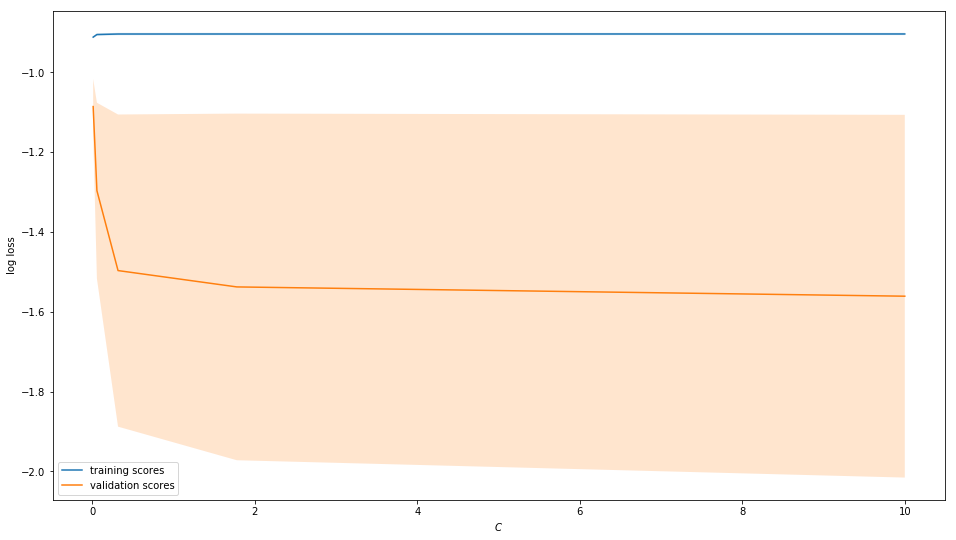

In [24]:
plt.rcParams['figure.figsize'] = 16,9
plot_with_err(C_vals, val_train, label='training scores')
plot_with_err(C_vals, val_test, label='validation scores')
plt.xlabel(r'$C$'); plt.ylabel('log loss')
plt.legend();

На основе анализа кривых валидации можно сделать вывод, что наша модель переобучена, т.к. в LogisticRegression меньшим значениям "C" соответствует большая регуляризация.

#### Построим кривые обучения

In [13]:
from sklearn.metrics import log_loss

In [26]:
log_loss_scorer = make_scorer(lambda y_true, y_pred: log_loss(y_true, y_pred, labels=np.unique(y_true)), needs_proba=True)

In [ ]:
clf_logit = LogisticRegression(random_state=17, 
                               n_jobs=4,
                               C=0.01,
                               multi_class='multinomial', 
                               solver='lbfgs')
    
N_train, val_train, val_test = learning_curve(clf_logit,
                                              X_train, y, 
                                              #groups=y,
                                              #train_sizes=train_sizes, 
                                              cv=3,
                                              n_jobs=1, 
                                              verbose=1,
                                              scoring=ndcg_scorer)

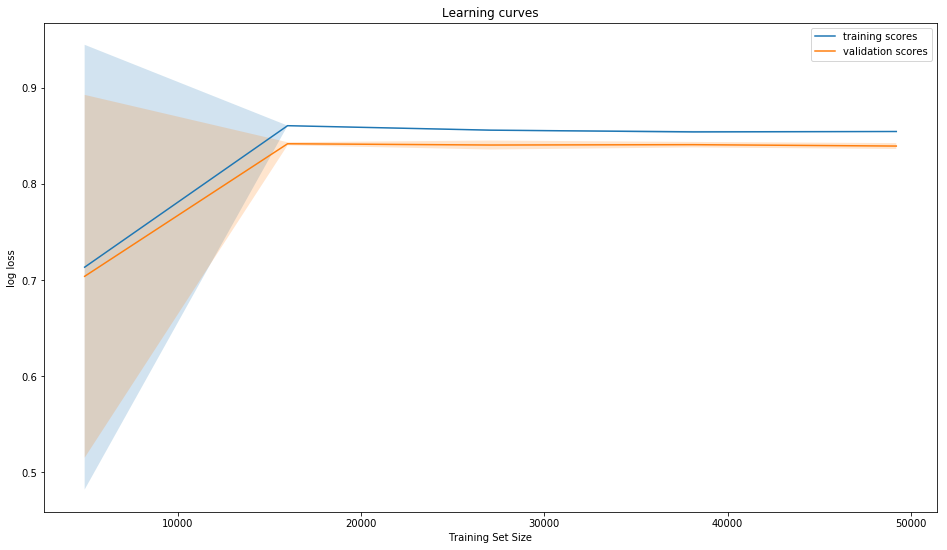

In [29]:
plt.rcParams['figure.figsize'] = 16,9
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('log loss')
plt.title("Learning curves")
plt.legend()

На кривой обучения мы видим, что метрики качества на обучающающей и валидационной выборках сходятся после примерно 15000 наблюдений. Далее они практически не меняются.

### _Градиентный бустинг (XGBoost)_

#### Подбираем базовое количество деревьев

XGBoost имеет большое количество тонких настроек. Вначале мы попробуем подобрать оптимальное количество деревьев (n_estimators) при помощи встроенной функции кросс-валидации xgboost. Из-за ограничения в вычислительных ресурсах мы не будем проверять значения n_estimators больше 100.

In [204]:
# Кастомная реализация метрики NDCG
def ndcg5_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

In [21]:
%%time
xgtrain = xgb.DMatrix(X_train_part, label=y_train_part)

Wall time: 4.09 s


In [30]:
param = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'nthread': 8,
    'n_jobs': -1,
    'seed': 17
}

Запускаем встроенную функцию кросс-валидации xgboost

In [30]:
%%time
cvresult = xgb.cv(param, 
                  xgtrain, 
                  num_boost_round=100, 
                  metrics=['mlogloss'], 
                  feval=ndcg5_score, 
                  maximize=True,
                  #nfold=5,
                  seed=17, 
                  early_stopping_rounds=50, 
                  verbose_eval=True)

[0]	train-mlogloss:2.1769+0.00158542	train-ndcg5:0.854036+0.00220826	test-mlogloss:2.17893+0.00300357	test-ndcg5:0.849863+0.00446812
[1]	train-mlogloss:1.97834+0.000712662	train-ndcg5:0.857144+0.000197151	test-mlogloss:1.98218+0.00300686	test-ndcg5:0.852403+0.00250982
[2]	train-mlogloss:1.82975+0.000148818	train-ndcg5:0.857902+0.0002779	test-mlogloss:1.83529+0.002779	test-ndcg5:0.852685+0.00246347
[3]	train-mlogloss:1.71174+0.000604509	train-ndcg5:0.858332+0.000347534	test-mlogloss:1.71877+0.00276724	test-ndcg5:0.852931+0.00190701
[4]	train-mlogloss:1.61465+0.00117248	train-ndcg5:0.858895+0.000199557	test-mlogloss:1.62356+0.00225482	test-ndcg5:0.853029+0.00185321
[5]	train-mlogloss:1.53346+0.00100644	train-ndcg5:0.85884+0.000112937	test-mlogloss:1.54384+0.00297403	test-ndcg5:0.852768+0.0019597
[6]	train-mlogloss:1.46364+0.000838936	train-ndcg5:0.859291+0.000122652	test-mlogloss:1.47565+0.00349438	test-ndcg5:0.852888+0.00215388
[7]	train-mlogloss:1.40322+0.00153401	train-ndcg5:0.859593+

[61]	train-mlogloss:0.822406+0.00269136	train-ndcg5:0.874789+0.000500536	test-mlogloss:0.921414+0.00485215	test-ndcg5:0.85492+0.00129989
[62]	train-mlogloss:0.820479+0.0027446	train-ndcg5:0.874985+0.000572014	test-mlogloss:0.921065+0.00483551	test-ndcg5:0.854961+0.00140634
[63]	train-mlogloss:0.818775+0.00269652	train-ndcg5:0.875138+0.000484875	test-mlogloss:0.920771+0.00485801	test-ndcg5:0.85495+0.00141899
[64]	train-mlogloss:0.81692+0.00265637	train-ndcg5:0.875428+0.000486507	test-mlogloss:0.920505+0.00488667	test-ndcg5:0.854903+0.00145165
[65]	train-mlogloss:0.814952+0.00266866	train-ndcg5:0.875705+0.000561698	test-mlogloss:0.920214+0.00493572	test-ndcg5:0.854948+0.00144846
[66]	train-mlogloss:0.813071+0.00257396	train-ndcg5:0.875895+0.000533417	test-mlogloss:0.920009+0.00495257	test-ndcg5:0.854906+0.00145529
[67]	train-mlogloss:0.811308+0.00250714	train-ndcg5:0.876186+0.000522817	test-mlogloss:0.919745+0.00499178	test-ndcg5:0.855002+0.00154235
[68]	train-mlogloss:0.809654+0.0024880

In [33]:
cvresult.shape[0]

100

Мы уперлись в ограничение на количество деревьев. Возможно, имеется потенциал дальнейшего улучшения, но из-за вычислительных ограничений мы остановимся на n_estimators=100.

#### Прогноз на отложенной выборке

In [102]:
xgb1 = XGBClassifier(
     learning_rate=0.1,
     min_child_weight=1,
     n_estimators=100,
     max_depth=5,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='multi:softprob',
     num_class=12,
     scale_pos_weight=1,
     reg_alpha=0,
     reg_lambda=1,
     nthread=8,
     n_jobs=-1,
     seed=17
)

In [103]:
%%time
xgb1.fit(X_train_part, y_train_part)
y_predict = xgb1.predict_proba(X_valid)

Wall time: 2min 58s


In [104]:
%%time
my_ndcg(y_valid, y_predict, k=5)

Wall time: 87.3 ms


0.8541637026393089

In [35]:
%%time
xgb1.fit(X_train, y)
y_predict = xgb1.predict_proba(X_test)

Wall time: 4min 19s


In [119]:
create_submission(y_predict, df_test.index, y_enc, 'sub_xgb_100.csv')

Данный сабмит получил public LB - 0.88039, private LB - 0.88552

#### Настройка параметров XGBoost

Из-за ограничения вычислительных ресурсов и особенностей пространства признаков задачи (много разреженных переменных) сделать полноценный поиск оптимальных параметров XGBoost не представляется возможным. Нам не удалось за разумное время посчитать при помощи GridSearch и кросс-валидации на 3 фолда оптимальные параметры, поэтому мы использовали более простую схему ручного перебора - без кросс-валидации, но с оценкой на валидационной (отложенной) выборке. В результате получены следующие "оптимальные" параметры:

In [93]:
xgb1 = XGBClassifier(
     learning_rate=0.1,
     min_child_weight=1,
     n_estimators=100,
     max_depth=5,
     gamma=0.5,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='multi:softprob',
     num_class=12,
     scale_pos_weight=1,
     reg_alpha=0,
     reg_lambda=1,
     nthread=8,
     n_jobs=-1,
     seed=17
)

#### Прогноз на отложенной выборке

In [94]:
%%time
xgb1.fit(X_train_part, y_train_part)
y_predict = xgb1.predict_proba(X_valid)

Wall time: 4min 7s


In [95]:
my_ndcg(y_valid, y_predict, k=5)

0.8544790784551072

#### Прогноз на тестовой выборке и сабмит

In [202]:
%%time
xgb1.fit(X_train, y)
y_predict = xgb1.predict_proba(X_test)

Wall time: 4min 39s


In [203]:
create_submission(y_predict, df_test.index, y_enc, 'sub_xgb_100_tune.csv')

Данный сабмит получил public LB - 0.88052, private LB - 0.88559.

### Часть 11. Выводы 

В результате применения более сложного семейства моделей - градиентного бустинга - нам удалось повысить качество прогноза на тестовой выборке, однако это было сделано ценой значительно больших вычислительных ресурсов и времени. Целевая метрика получилась довольно высокой 0.88559 (private LB), что говорит о хорошем качестве прогноза. На момент выполнения проекта соревнование на Kaggle уже было завершено, но по текущим показателям в лидерборде мой сабмит находится на 95 месте (top 6%).

Результаты прогноза наиболее вероятной страны первого бронирования позволят оптимизировать показ рекламных баннеров и почтовую рассылку, сделает ее более персонализированной. Это в свою очередь позволит увеличить степень использования сервиса новыми клиентами и снизить среднее время от регистрации до первого бронирования.

**Если у вас возникнут вопросы, замечания или вы хотите поделиться своими мыслями по поводу этого проекта и подходов описанных в нем, то в ODS slack вы можете меня найти @konobey**